In [52]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from mpl_toolkits.mplot3d import Axes3D
# from unidecode import unidecode
import numpy as np
import matplotlib.pyplot as plt
import random, sys, io, re, csv

In [32]:
csv_reader = csv.reader(open('data/Lana_del_rey/lyrics.csv', encoding='utf-8'))

In [33]:
# return a dictionary of song: lyrics
def get_tokenized_lines(csv):
    lyrics = {}
    for r in csv:
        words = []
        row = str(r[2]).lower()
        for line in row.split('|-|'):
            new_words = re.findall(r"\b[a-z']+\b", line)
            words = words + new_words
        lyrics[r[1]] = words
    return lyrics

In [34]:
all_lyric_words = get_tokenized_lines(csv_reader)

In [35]:
# total word number: 173631, total lines of lyrics: 22688, average word per line: 7.652988

SEQ_LENGTH = 32 + 1 # this one will be deleted during prediction, "1" stands for using a sequence to generate one word
sequences = list()

def get_all_sequences():
    for song in all_lyric_words:
        if len(all_lyric_words[song]) < SEQ_LENGTH:
            sequences.append(all_lyric_words[song])
        else:
            for i in range(SEQ_LENGTH, len(all_lyric_words[song])):
                seq = all_lyric_words[song][i - SEQ_LENGTH: i]
                sequences.append(seq)
    
    return sequences

In [36]:
sequences = get_all_sequences()
print('Total Sequences: %d' % len(sequences))

Total Sequences: 66117


In [37]:
# store all the unique words and match them with indices
all_words = []
for song in all_lyric_words:
    for word in all_lyric_words[song]:
        all_words.append(word)
unique_word = set(all_words)
word_to_index = {w: i for i, w in enumerate(unique_word)}
index_to_word = {i: w for w, i in word_to_index.items()}
word_indices = [word_to_index[word] for word in unique_word]
word_size = len(unique_word)

print('vocabulary size: {}'.format(word_size))

vocabulary size: 3810


In [38]:
# this funtion change the words into matrix wise data, and each position of the matrix stands for the index of the word in index_to_word

def data_to_matrix(lines, seq_len):
    matrix = np.zeros((len(lines), seq_len))
    for r, line in enumerate(lines):
        for c, word in enumerate(line):
            matrix[r, c] = word_to_index[word]

    return matrix

In [39]:
matrix_data = data_to_matrix(sequences, SEQ_LENGTH)

In [40]:
matrix_data[:,-1].shape

(66117,)

In [41]:
# get the y = Wx data, X is the input data, and y is the target data
X, y = matrix_data[:, :-1], matrix_data[:, -1]
y = to_categorical(y, num_classes=word_size) # to_categorical: for categorical_crossentropy optimiser
seq_length = len(X[0]) # 32 in our case, stands for sequence length

In [42]:
print("X_shape", X.shape)
print("y_shape", y.shape)

X_shape (66117, 32)
y_shape (66117, 3810)


In [43]:
# establish the network, using LSTM and compile it
model = Sequential()
model.add(Embedding(word_size, 32, input_length=seq_length)) # Embedding(input_dim, output_dim, input_length), which respecively stands for: the possible value of the word, the output vector size, sequence length
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(word_size, activation='softmax'))
print(model.summary())

adam = Adam(0.002)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(X, y, batch_size=128, epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 32, 32)            121920    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32, 100)           53200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 3810)              384810    
Total params: 650,430
Trainable params: 650,430
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
66117/66117 [==============================] - 129s - loss: 6.1180 - acc: 0.0419   
Epoch 2/50
66117/66117 [============

In [14]:
model.save('model.h5') # this now stores the model for kanye west's training

In [44]:
# transfer text to a numpy matrix
def text_to_matrix(texts, word_to_index):
    indices = np.zeros((1, len(texts)), dtype=int)
    
    for i, text in enumerate(texts):
        indices[:, i] = word_to_index[text]
        
    return indices

In [45]:
# ensure seach sequence is no longer than max length
def my_pad_sequences(seq, max_length):
    start = seq.shape[1] - max_length
    return seq[:, start: start + max_length]

In [48]:
# generate lyrics
def generate_text(model, word_to_index, seq_length, seed_text, num_of_words):
    result = list()[1:]
    input_text = seed_text.lower()

    for num in range(num_of_words):
        encoded = text_to_matrix(input_text.split(), word_to_index)
        encoded = my_pad_sequences(encoded, max_length=seq_length)
        predict = model.predict_classes(encoded, verbose=0)
        out_word = ''
    
        for word, index in word_to_index.items():
            if index == predict:
                out_word = word
                break
        
        input_text += ' ' + out_word
        result.append(out_word)
        
    return ' '.join(result)

In [50]:
# this is for lana del rey
# make sure the seed text has length 32 and without puntuations
seed_text = "kiss me hard before you go summertime sadness I just wanted you to know that baby you the best I got my red dress on tonight dancing in the dark in the pale moonlight"
generated = generate_text(model, word_to_index, SEQ_LENGTH - 1, seed_text, 50)
print(generated)

done my hair up real big beauty queen style high heels and don't wanna fall in love with a in love with you but i lost myself when i lost you but i still don't tell me hey of a dime of bay like you seem and now you miss


In [31]:
# this is what we got for Kanye West !!!
seed_text = "Bougie girl grab her hand fuck that bitch she don't wanna dance excuse my French but I'm in France Prince williams ain't do it right if you ask me cause if I"
generated = generate_text(model, word_to_index, SEQ_LENGTH - 1, seed_text, 50)
print(generated)

was gassin me or just a train blaow blang my niggas holding a bad bitch and you know what i did i was on a mil million seconds flash and breathe and breathe and breathe and breathe and breathe and calm down and i know you know i was three


In [59]:
model = load_model('model.h5')
weights = model.layers[4].get_weights()[0].reshape(-1,3)

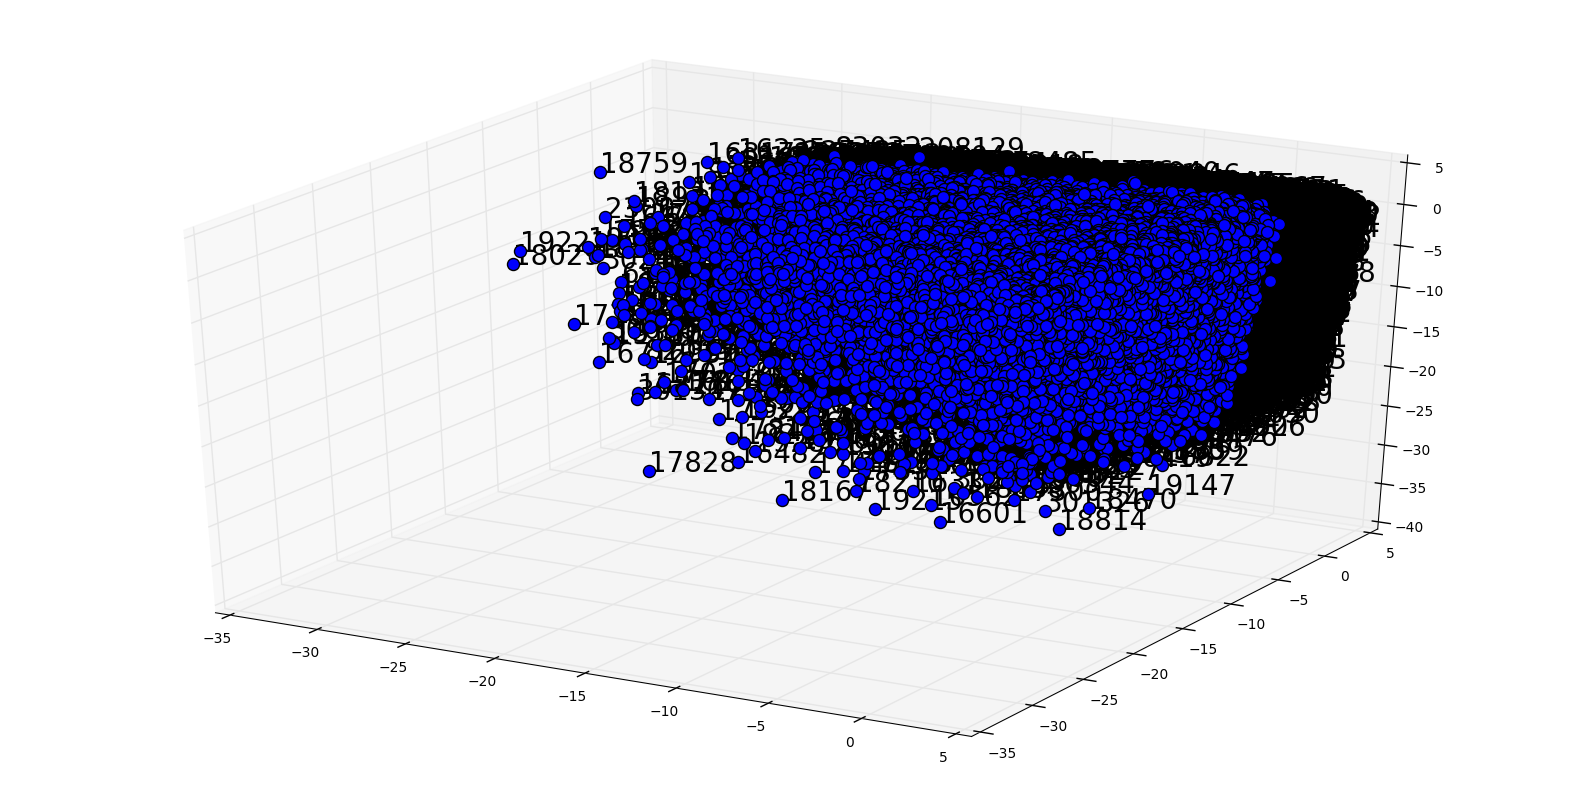

In [62]:
def plot_3d(weights):
    figure = plt.figure(figsize=(20,10))
    ax = figure.add_subplot(111, projection='3d')
    for i in range(0, len(weights)):
        ax.scatter(weights[i, 0], weights[i, 1], weights[i, 2], s = 75)
        ax.text(weights[i,0], weights[i,1],weights[i,2], '%s' % (str(i)), size = 20, zorder = 1, color = 'k')
    plt.show()

plot_3d(weights)